In [2]:
import gymnasium as gym
import numpy as np
from stable_baselines3.common.env_util import make_vec_env
from copy import deepcopy
import torch
from torch.distributions import Normal
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
from torch.utils.data import Dataset, DataLoader
from stable_baselines3.common.vec_env import VecVideoRecorder, DummyVecEnv
import imageio
import pandas as pd
from tqdm import tqdm
from PIL import Image
from stable_baselines3.dqn.policies import MlpPolicy
import matplotlib.pyplot as plt


In [3]:
import gc
gc.collect()

0

In [4]:
!nvidia-smi
# clean up memory forcefully
torch.cuda.empty_cache()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device




Tue Apr  2 04:29:55 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.06              Driver Version: 545.23.06    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1080 Ti     On  | 00000000:01:00.0 Off |                  N/A |
|  8%   53C    P2              58W / 250W |    218MiB / 11264MiB |      6%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

device(type='cuda')

In [5]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
class CustomDataset(Dataset):
    def __init__(self, observations, actions):
        self.observations = torch.tensor(observations, dtype=torch.float32,device=device)
        self.actions = torch.tensor(actions, dtype=torch.float32,device=device)

    def __len__(self):
        return len(self.observations)

    def __getitem__(self, idx):
        observation = self.observations[idx]
        action = self.actions[idx]
        return observation, action

class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 32)
        self.norm1 = nn.LayerNorm(32)
        self.fc2 = nn.Linear(32, 32)
        self.norm2 = nn.LayerNorm(32)
        self.fc3 = nn.Linear(32, output_dim)

    def forward(self, x):
        x = F.relu(self.norm1(self.fc1(x)))
        x = F.relu(self.norm2(self.fc2(x)))
        x = self.fc3(x)
        return x

    

Using device: cuda


In [6]:
env_id = "CartPole-v1"
# env = make_vec_env(env_id, n_envs=1)
# read /mnt/nfs/work/c98181/RL/dataset/CartPole-v1...npy
observations= np.load("/mnt/nfs/work/c98181/RL/dataset/CartPole-v1_28000_obs.npy", allow_pickle=True)
actions = np.load("/mnt/nfs/work/c98181/RL/dataset/CartPole-v1_28000_actions.npy", allow_pickle=True)
observations=observations.squeeze()
actions=actions.squeeze()
# observations = observations[:1000]
# actions = actions[:1000]
print(observations.shape, actions.shape)
print(observations[0], actions[0])

# print(actions)

(28000, 4) (28000,)
[-0.04564106 -0.20030153  0.01773192  0.32664654] 0


In [7]:
class mydataset(Dataset):
    def __init__(self, observations, actions):
        self.observations = torch.tensor(observations, dtype=torch.float32).to(device)
        self.actions = torch.tensor(actions, dtype=torch.float32).to(device)

    def __len__(self):
        return len(self.observations)

    def __getitem__(self, idx):
        observation = self.observations[idx]
        action = self.actions[idx]
        return observation, action

In [8]:
# show line number below


policy_network = PolicyNetwork(
    4, 2).to(device)
# nn init kaiming
# torch.nn.init.kaiming_normal_(policy_network.fc1.weight)
# torch.nn.init.kaiming_normal_(policy_network.fc2.weight)
# torch.nn.init.kaiming_normal_(policy_network.fc3.weight)

# build training set and validation set
train_size = int(1* len(observations))
train_observations = observations[:train_size]
train_actions = actions[:train_size]
# val_observations = observations[train_size:]
# val_actions = actions[train_size:]

# build dataset
train_dataset = CustomDataset(train_observations, train_actions)
# val_dataset = CustomDataset(val_observations, val_actions)


optimizer = torch.optim.Adam(policy_network.parameters(), lr=0.0017601048183920826,weight_decay=2.350251568550711e-5,eps=1e-8)


# Training loop
num_epochs = 50
batch_size = 16

train_dataloader = DataLoader(train_dataset , batch_size=batch_size, shuffle=True)
# val_dataloader = DataLoader(val_dataset , batch_size=batch_size, shuffle=True)
loss_func = nn.CrossEntropyLoss()

graph=[]
val_losses=[]
eval_rewards=[]
for epoch in range(num_epochs):

    policy_network.train()

    # Compute the log probabilities of the actions
    pbar=tqdm(train_dataloader,position=0,leave=True)
    loss_record=[]

    for step, (obs_batch,act_batch) in enumerate(pbar):

        
        logits = policy_network(obs_batch)
        # cross entropy
        loss=loss_func(logits, act_batch.long())
        
        # Optimize the policy
        optimizer.zero_grad()

        loss.backward()
        optimizer.step()

        pbar.set_description((f"Epoch [{epoch+1}/{num_epochs}]"))
        pbar.set_postfix({"loss":loss.detach().item()})


        #scheduler

        loss_record.append(loss.detach().item())
    # scheduler.step()
    graph.append(sum(loss_record)/len(loss_record))
    # with torch.no_grad():
    #     # validation_loss
    #     val_loss_record=[]
    #     for step, (obs_batch,act_batch) in enumerate(val_dataloader):
    #         logits = policy_network(obs_batch)
    #         loss = loss_func(logits, act_batch.long())
    #         val_loss_record.append(loss.detach().item())
    #     val_loss = sum(val_loss_record)/len(val_loss_record)
    #     val_losses.append(val_loss)
    
    policy_network.eval()  # 切换到评估模式

    env = make_vec_env(env_id, n_envs=1)
    # test ten times
    total_reward=0
    num_test = 50
    for _ in range(num_test):
        state = env.reset()
        done = False
        
        # test the policy and save as gif
        frames = []
        while not done:
            state_tensor = torch.tensor(state, dtype=torch.float32).to(device)
            # print(state_tensor.shape)
            with torch.no_grad():
                pred= policy_network(state_tensor)
                action = torch.argmax(pred).cpu().numpy()
                
            state, reward, done, _ = env.step([action])  # 执行动作
            total_reward += reward
            frame = env.render(mode="rgb_array")  # 获取当前环境的图像
            frames.append(frame)  # 添加到帧列表中

    # 保存为GIF
    image_path = f"cartpole_epoch_{epoch+1}.gif"
    imageio.mimsave("/mnt/nfs/work/c98181/RL/result/test/"+image_path, frames)  # duration控制帧切换的速度


    env.close()
    print(total_reward/num_test)
    
    eval_rewards.append(total_reward/num_test)


Epoch [1/50]: 100%|██████████| 1750/1750 [00:05<00:00, 349.02it/s, loss=0.165]  


[9.82]


Epoch [2/50]:  73%|███████▎  | 1284/1750 [00:03<00:01, 357.26it/s, loss=0.123]  


KeyboardInterrupt: 

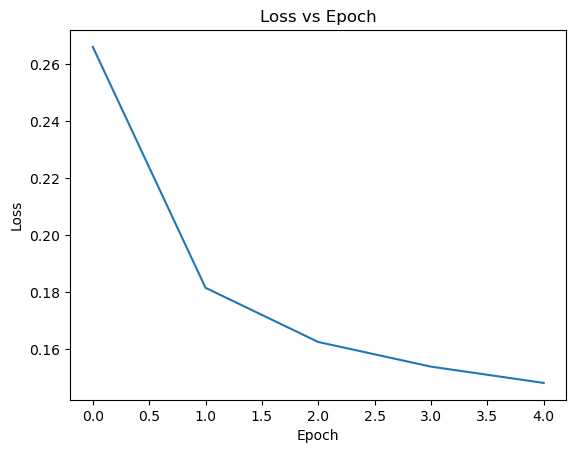

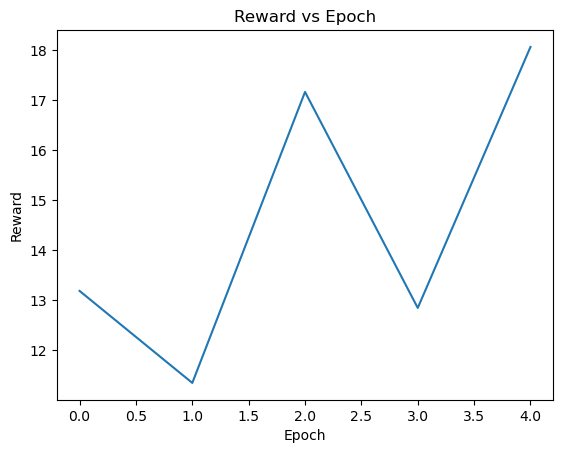

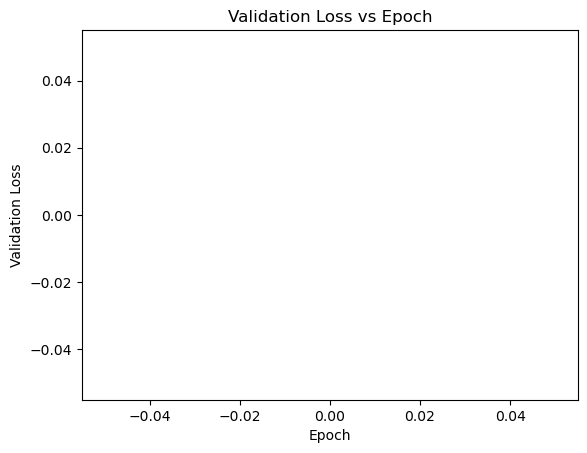

In [ ]:
# draw the loss graph
import matplotlib.pyplot as plt
plt.plot(graph)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epoch")
plt.show()

# draw the reward graph
plt.plot(eval_rewards)
plt.xlabel("Epoch")
plt.ylabel("Reward")
plt.title("Reward vs Epoch")
plt.show()
# draw the validation loss graph
plt.plot(val_losses)
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.title("Validation Loss vs Epoch")
plt.show()



In [1]:
import numpy as np
import gymnasium as gym
from imitation.policies.serialize import load_policy
from imitation.util.util import make_vec_env
from imitation.data.wrappers import RolloutInfoWrapper

env = make_vec_env(
    "seals:seals/CartPole-v0",
    rng=np.random.default_rng(),
    post_wrappers=[
        lambda env, _: RolloutInfoWrapper(env)
    ],  # needed for computing rollouts later
)
expert = load_policy(
    "ppo-huggingface",
    organization="HumanCompatibleAI",
    env_name="seals/CartPole-v0",
    venv=env,
)

/mnt/nfs/work/c98181/miniconda3/envs/atari/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from stable_baselines3.common.evaluation import evaluate_policy

reward, _ = evaluate_policy(expert, env, 10)
print(reward)

500.0


In [3]:
from imitation.data import rollout

rng = np.random.default_rng()
rollouts = rollout.rollout(
    expert,
    env,
    rollout.make_sample_until(min_timesteps=None, min_episodes=50),
    rng=rng,
)
transitions = rollout.flatten_trajectories(rollouts)

In [4]:
print(
    f"""The `rollout` function generated a list of {len(rollouts)} {type(rollouts[0])}.
After flattening, this list is turned into a {type(transitions)} object containing {len(transitions)} transitions.
The transitions object contains arrays for: {', '.join(transitions.__dict__.keys())}."
"""
)

The `rollout` function generated a list of 56 <class 'imitation.data.types.TrajectoryWithRew'>.
After flattening, this list is turned into a <class 'imitation.data.types.Transitions'> object containing 28000 transitions.
The transitions object contains arrays for: obs, acts, infos, next_obs, dones."



In [15]:
from imitation.algorithms import bc
bc_trainer = bc.BC(
    observation_space=env.observation_space,
    action_space=env.action_space,
    demonstrations=transitions,
    rng=rng,
    device="cpu"
)
print(bc_trainer.policy)

FeedForward32Policy(
  (features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (pi_features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (vf_features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (mlp_extractor): MlpExtractor(
    (policy_net): Sequential(
      (0): Linear(in_features=4, out_features=32, bias=True)
      (1): Tanh()
      (2): Linear(in_features=32, out_features=32, bias=True)
      (3): Tanh()
    )
    (value_net): Sequential(
      (0): Linear(in_features=4, out_features=32, bias=True)
      (1): Tanh()
      (2): Linear(in_features=32, out_features=32, bias=True)
      (3): Tanh()
    )
  )
  (action_net): Linear(in_features=32, out_features=2, bias=True)
  (value_net): Linear(in_features=32, out_features=1, bias=True)
)


In [12]:
reward_before_training, _ = evaluate_policy(bc_trainer.policy, env, 10)
print(f"Reward before training: {reward_before_training}")

Reward before training: 26.4


In [14]:
bc_trainer.train(n_epochs=1)
reward_after_training, _ = evaluate_policy(bc_trainer.policy, env, 10)
print(f"Reward after training: {reward_after_training}")

0batch [00:00, ?batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 0         |
|    ent_loss       | -0.000326 |
|    entropy        | 0.326     |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 96.1      |
|    loss           | 0.35      |
|    neglogp        | 0.351     |
|    prob_true_act  | 0.781     |
|    samples_so_far | 32        |
---------------------------------


465batch [00:01, 465.31batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 500       |
|    ent_loss       | -0.000348 |
|    entropy        | 0.348     |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 100       |
|    loss           | 0.295     |
|    neglogp        | 0.296     |
|    prob_true_act  | 0.794     |
|    samples_so_far | 16032     |
---------------------------------


875batch [00:01, 461.71batch/s]


Reward after training: 500.0
